# Setup:

In [21]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 200)
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use("seaborn-v0_8-darkgrid")
import seaborn as sns
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200 , 'figure.figsize': (10, 5)})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_style('darkgrid')
import os
import warnings
warnings.filterwarnings('ignore')
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [22]:
df = pd.read_excel(("DATA.xlsx"), sheet_name = None)
INFLATION, CPI, CRUDE_OIL, HOUSE, ELECTRICITY = df["INFLATION"].set_index("Date").resample("M").mean(), df["CPI"].set_index("Date").resample("M").mean(), df["CRUDE_OIL"].set_index("Date").resample("M").mean(), (df["HOUSE"].set_index("Date")/3).resample("M").mean().fillna(method = "ffill"), (df["ELECTRICITY"].set_index("Date")/3).resample("M").mean().fillna(method = "ffill")

In [23]:
INFLATION_red = INFLATION.loc[np.intersect1d(INFLATION.index, ELECTRICITY.index)]
CPI_red = CPI.loc[np.intersect1d(CPI.index, ELECTRICITY.index)]
CRUDE_OIL_red = CRUDE_OIL.loc[np.intersect1d(CRUDE_OIL.index, ELECTRICITY.index)]
HOUSE_red = HOUSE.loc[np.intersect1d(HOUSE.index, ELECTRICITY.index)]
ELECTRICITY_red = ELECTRICITY
df_red = pd.concat([INFLATION_red, CPI_red, CRUDE_OIL_red, HOUSE_red, ELECTRICITY_red], axis = 1)

df_red_train = df_red.iloc[:-12]
df_red_test = df_red.iloc[-12:]

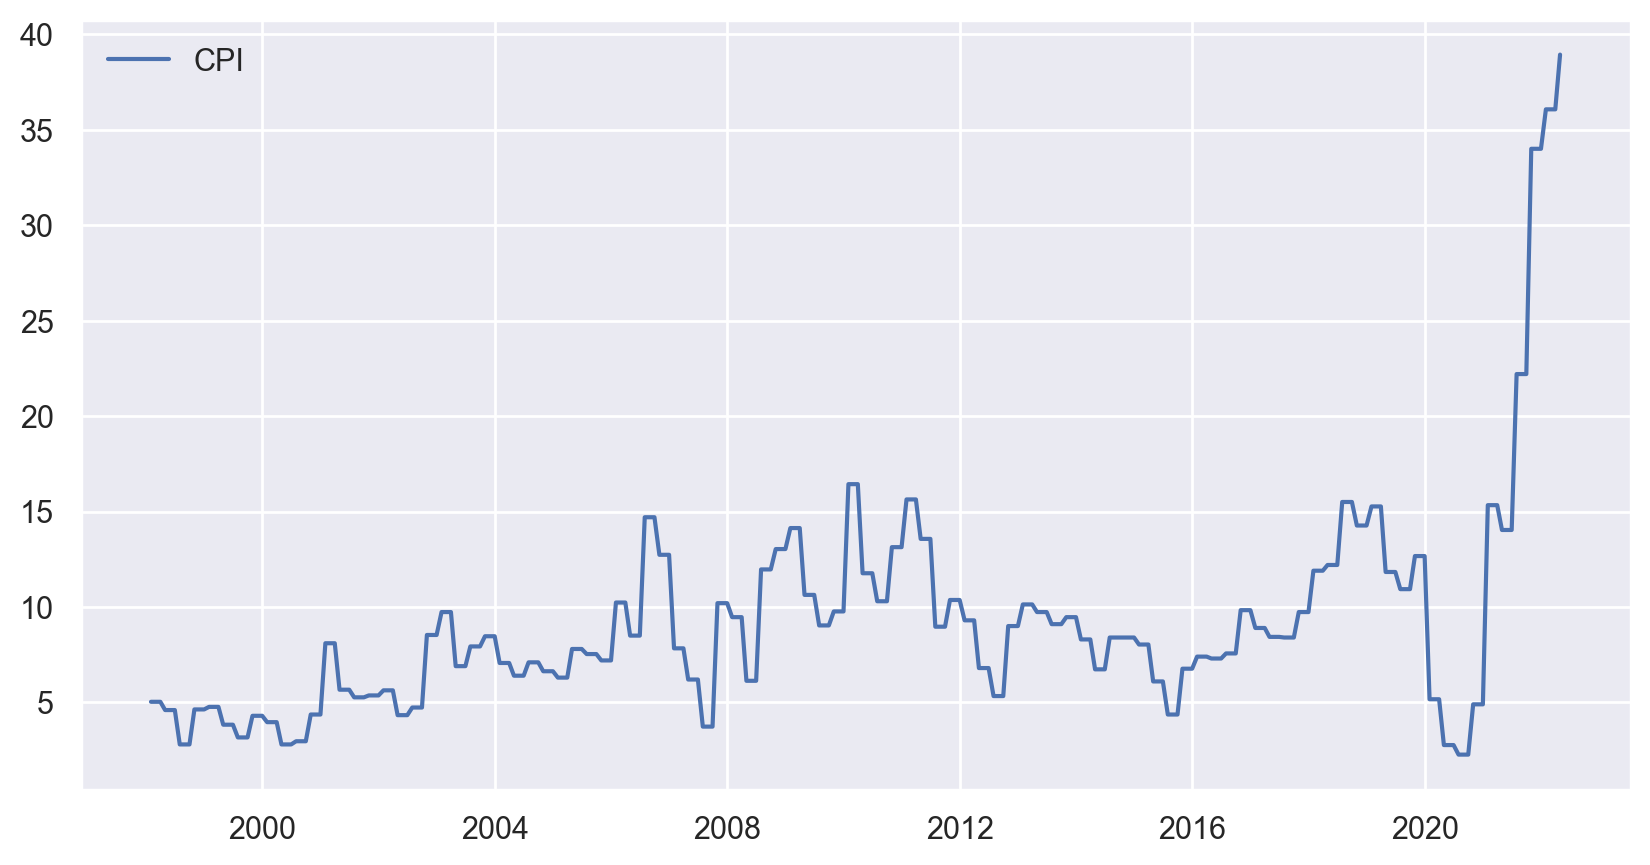

In [36]:
plt.plot(df_red_train["ELECTRICITY"], label = "CPI")
plt.legend()
plt.show()

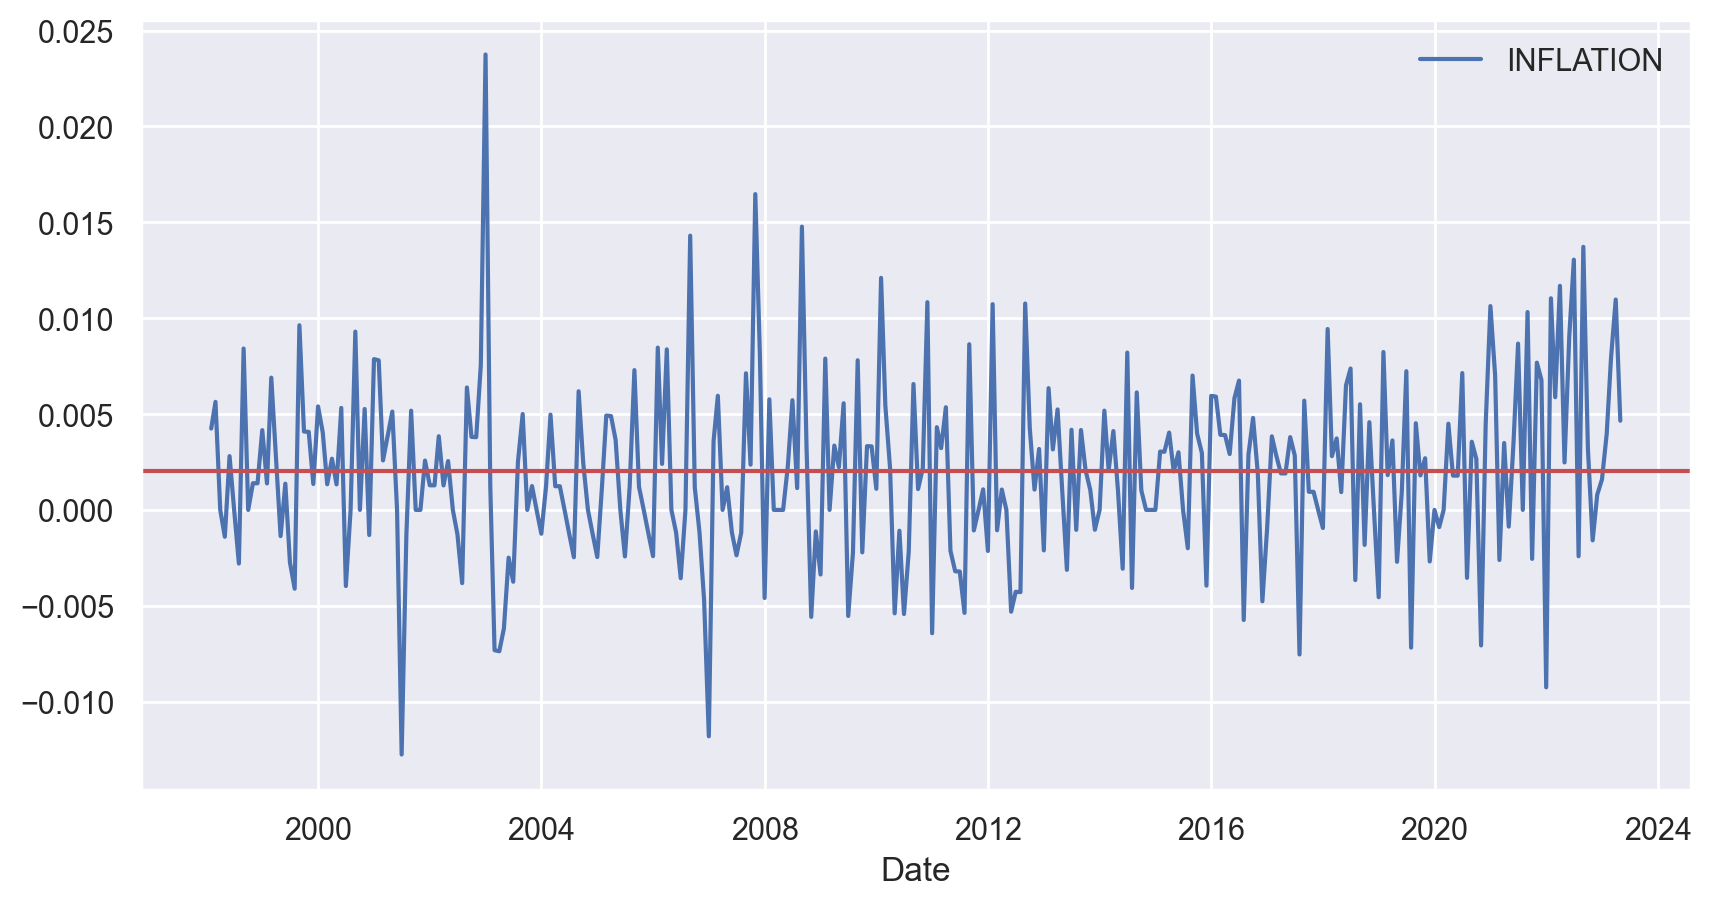

In [24]:
sns.lineplot(INFLATION_red, linewidth = 1.5)
plt.axhline(y = INFLATION_red.mean().tolist(), color = 'r', linestyle = '-')
plt.show()

In [25]:
def acf(x,lag):
    autocovariance = np.array([])
    x_mean = x.mean()
    n = len(x)
    for i in range(lag+1):
        sum_ = np.array([])
        for j in range(n-i):
            sum_ = np.append(sum_, (x[j+i]-x_mean)*(x[j]-x_mean))
        autocovariance = np.append(autocovariance, sum_.sum()/n)
    acf_ = np.transpose(autocovariance/autocovariance[0])
    acf_df = pd.DataFrame(acf_, columns = ["ACF"])
    acf_df.index.name = "Lag"
    return acf_

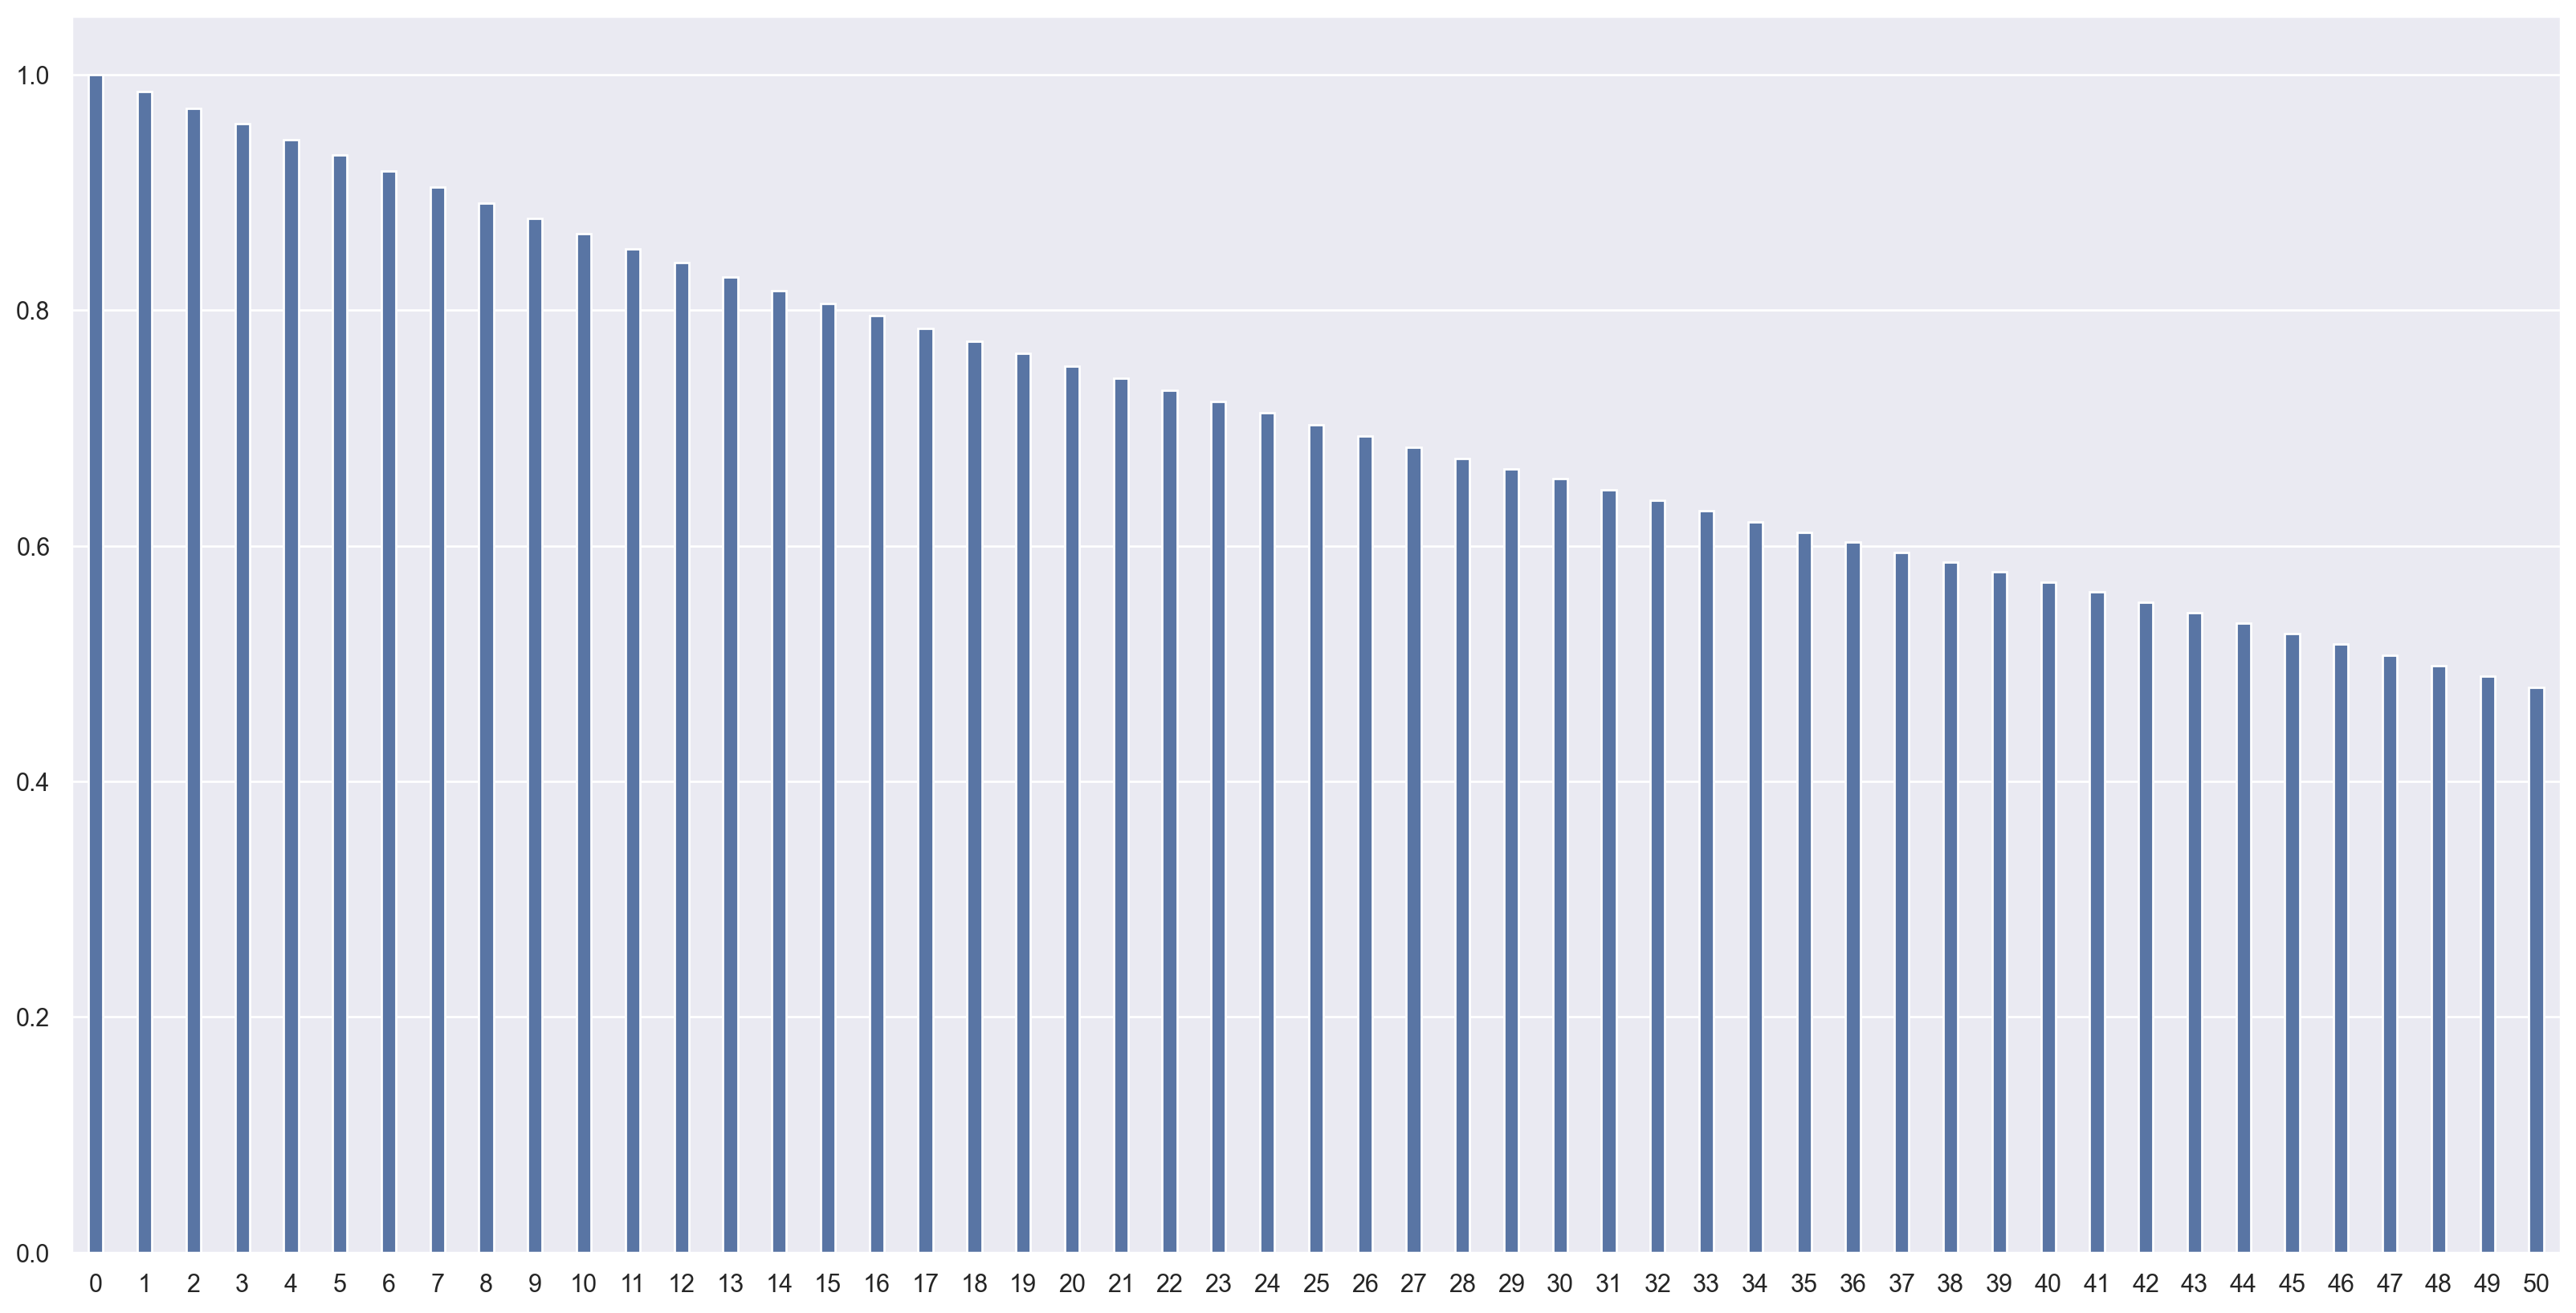

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(acf(CPI_red["CPI"], 50), width=0.3, ax = ax)
plt.show()

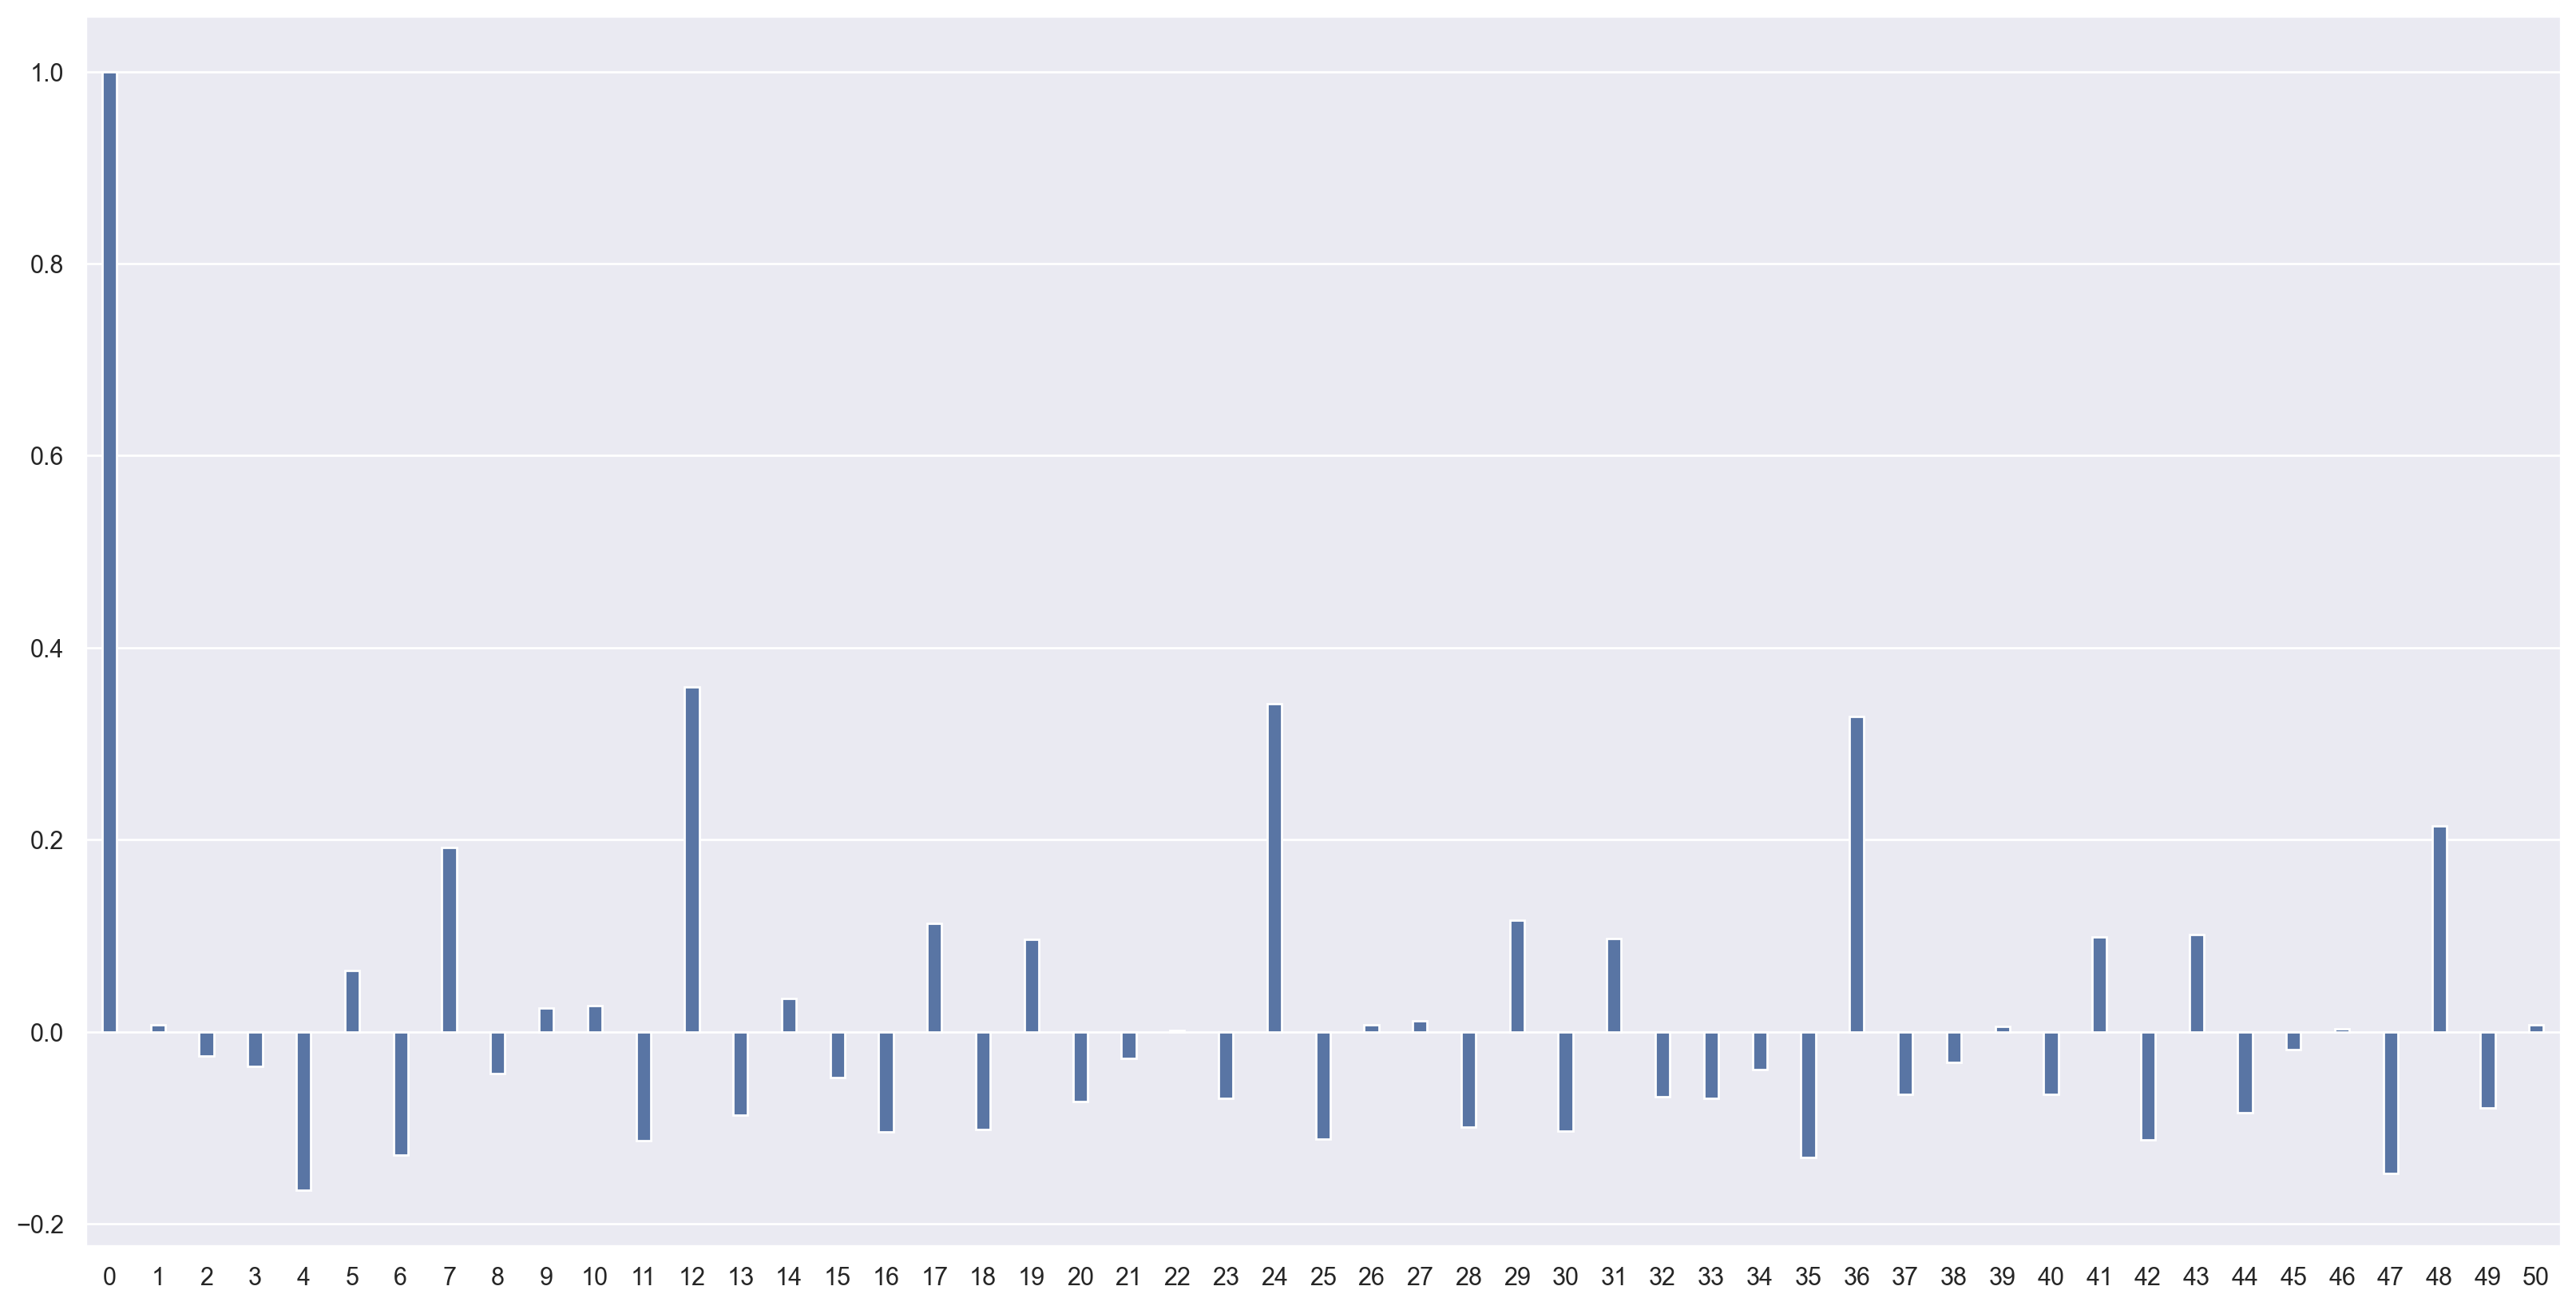

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(acf(INFLATION_red["INFLATION"], 50), width=0.3, ax = ax)
plt.show()

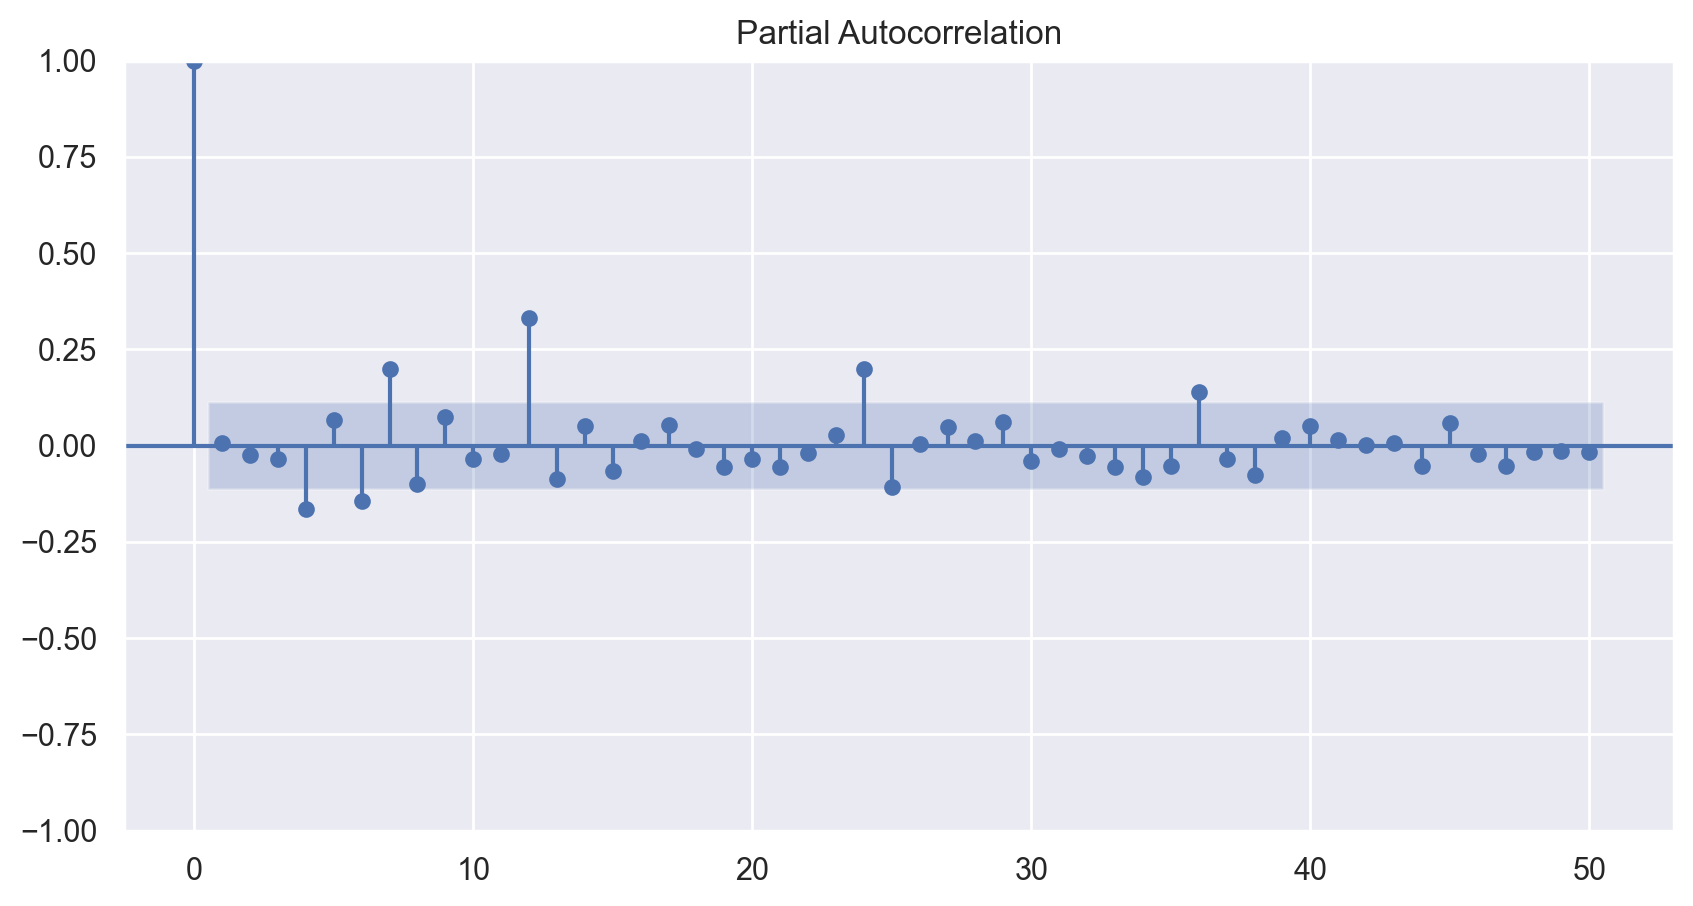

In [28]:
plot_pacf(INFLATION_red, lags=50)
plt.show()

ARIMA(0,0,0) model should work for inflation.

First we run the kalman filter over the data.

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
SARIMAX(df_red["INFLATION"], exog = df_red[["CRUDE_OIL", "HOUSE", "ELECTRICITY"]], order=(0,0,0), seasonal_order=(0,0,0,0)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              INFLATION   No. Observations:                  304
Model:                        SARIMAX   Log Likelihood                 487.146
Date:                Mon, 06 Nov 2023   AIC                           -966.291
Time:                        14:54:23   BIC                           -951.423
Sample:                    01-31-1998   HQIC                          -960.344
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
CRUDE_OIL    4.892e-08   1.07e-05      0.005      0.996   -2.08e-05    2.09e-05
HOUSE        1.997e-05      0.008      0.002      0.998      -0.016       0.016
ELECTRICITY  3.319e-05      0.010      0.003      0.997      -0.020       0.020
sigma2          0.0064      0.001      8.689      0.000       0.005       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                41.84
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.30
Prob(H) (two-sided):                  0.98   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""